In [1]:
import pandas as pd
import numpy as np
import mlfinlab as ml
import matplotlib.pyplot as plt

import pyfolio as pf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

DIR = 'data/10min/'

/home/dan/Apps/anaconda3/envs/financial-ml/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
df = pd.read_parquet(DIR + 'dollar.parq')['2018':'2019']
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2018-01-01 00:11:11.241,3381,13873.0,13920.0,13675.0,13763.5,678.428823,196.744402,3381,9.339762e+06
2018-01-01 00:27:14.652,6433,13763.5,13789.5,13596.0,13775.5,681.928406,359.159578,3052,9.340538e+06
2018-01-01 00:48:23.395,9291,13775.5,13780.5,13657.0,13745.0,681.494038,396.172220,2858,9.345154e+06
2018-01-01 01:09:43.777,12668,13745.0,13770.0,13555.5,13555.5,684.667367,253.573044,3377,9.341081e+06
2018-01-01 01:32:03.253,15130,13555.5,13737.5,13550.0,13650.5,690.498692,427.242852,2462,9.420639e+06


In [3]:
df = df[['high', 'low', 'close', 'volume', 'cum_dollar_value']]
df.columns = ['high', 'low', 'close', 'btc_volume', 'dollar_volume']

In [4]:
def fix_duplicated_indices(df):
    df.reset_index(inplace=True)
    deltas = pd.to_timedelta(df.groupby('date_time').cumcount(), unit='micro')
    df['date_time'] = df['date_time'] + deltas
    df.set_index('date_time', inplace=True)
    
    assert df.index.duplicated().sum() == 0

In [5]:
if df.index.duplicated().sum() > 0:
    fix_duplicated_indices(df)

## 1. Primary Model - Mean-reversion based on Bollinger Bands

In [6]:
def bbands(close, window, no_of_stdev):
    mean = close.ewm(span=window).mean()
    std = close.ewm(span=window).std()
    upper_band = mean + (std * no_of_stdev)
    lower_band = mean - (std * no_of_stdev)
    
    return mean, upper_band, lower_band

In [7]:
window = 50
df['avg'], df['upper'], df['lower'] = bbands(df.close, window, no_of_stdev=1)

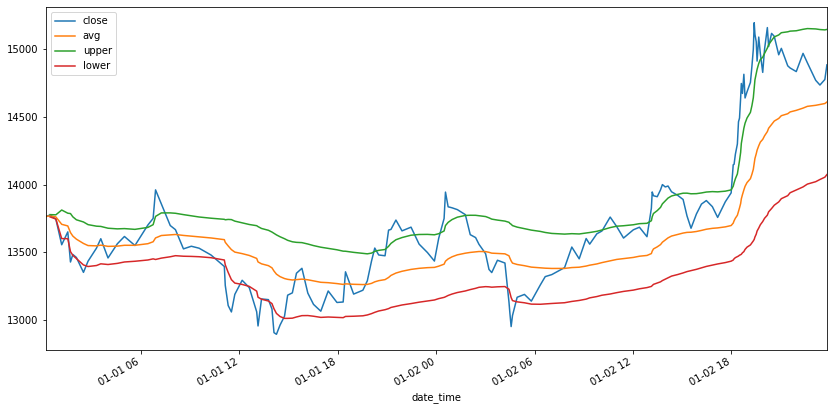

In [8]:
df[['close', 'avg', 'upper', 'lower']].loc['2018-01-01':'2018-01-02'].plot(figsize=(14, 7))

In [9]:
df.sample(10)

,high,low,close,btc_volume,dollar_volume,avg,upper,lower
date_time,,,,,,,,
2018-03-24 10:48:42.804,8782.0,8751.0,8751.5,1066.965772,9.356210e+06,8832.259662,8894.193264,8770.326060
2018-03-19 05:53:02.329,8325.0,8284.0,8325.0,1125.614899,9.341896e+06,8237.316613,8308.292457,8166.340769
2019-03-02 12:58:28.126,3813.5,3805.5,3809.5,2453.491918,9.348281e+06,3800.812650,3815.786794,3785.838506
2018-03-21 16:18:26.720,8894.5,8783.0,8870.0,1057.893226,9.344313e+06,9007.604605,9108.209701,8906.999510
2018-09-25 04:12:08.909,6472.0,6465.5,6467.5,1456.838263,9.424718e+06,6453.800323,6489.761225,6417.839421
2018-04-30 08:23:41.717,9200.0,9170.0,9190.0,1018.851393,9.354697e+06,9268.134249,9324.012829,9212.255669
2019-01-27 00:39:52.060,3551.0,3540.0,3551.0,2641.790772,9.365070e+06,3560.774126,3585.695906,3535.852347
2018-05-24 03:27:42.819,7630.0,7616.5,7616.5,1227.666079,9.356938e+06,7582.311456,7615.574802,7549.048110
2019-04-30 15:51:12.415,5255.5,5248.5,5255.5,1784.773207,9.374522e+06,5235.003882,5266.713354,5203.294410


In [10]:
df['side'] = np.nan

long_signals = (df.close <= df.lower)
short_signals = (df.close >= df.upper)

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df.side.shift(1)

In [11]:
raw_data = df.copy()

df.dropna(axis=0, how='any', inplace=True)

In [12]:
df.side.value_counts()

 1.0    16989
-1.0    16146
Name: side, dtype: int64

## 2. Label the events using the Triple-Barrier method

In [13]:
daily_volatility = ml.util.get_daily_vol(close=df.close, lookback=50)

In [14]:
cusum_events = ml.filters.cusum_filter(df.close, threshold=daily_volatility.mean())

In [15]:
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                    close=df.close,
                                                    num_days=1)

In [16]:
pt_sl = [1, 1]
min_ret = 0.005,

triple_barrier_events = ml.labeling.get_events(close=df.close,
                                              t_events=cusum_events,
                                              pt_sl=pt_sl,
                                              target=daily_volatility,
                                              min_ret=min_ret,
                                              num_threads=4,
                                              vertical_barrier_times=vertical_barriers,
                                              side_prediction=df.side)

2020-05-25 12:23:15.266425 100.0% apply_pt_sl_on_t1 done after 0.04 minutes. Remaining 0.0 minutes.


<br><br>

**Get the labels (the bin column):**

    0  means the signal given by the primary model was false
    1  means the signal was correct

In [17]:
labels = ml.labeling.get_bins(triple_barrier_events, df.close)
labels

,ret,trgt,bin,side
2018-01-02 04:29:43.506,0.049042,0.021622,1,1.0
2018-01-02 11:00:31.665,-0.020919,0.021151,0,-1.0
2018-01-02 18:10:04.143,-0.044887,0.043610,0,-1.0
2018-01-02 18:29:57.805,-0.046361,0.046362,0,-1.0
2018-01-02 19:15:22.765,-0.011431,0.051113,0,-1.0
...,...,...,...,...
2019-04-26 11:05:03.479,-0.017510,0.015411,0,1.0
2019-04-26 16:29:06.910,0.022552,0.012958,1,1.0
2019-04-26 22:06:34.975,0.003494,0.021569,0,-1.0
2019-04-28 19:31:36.670,0.003831,0.021822,0,1.0


## 3. Results of the primary model

In [18]:
primary_results = pd.DataFrame({'actual': labels['bin'], 'pred': 1})
primary_results

,actual,pred
2018-01-02 04:29:43.506,1,1
2018-01-02 11:00:31.665,0,1
2018-01-02 18:10:04.143,0,1
2018-01-02 18:29:57.805,0,1
2018-01-02 19:15:22.765,0,1
...,...,...
2019-04-26 11:05:03.479,0,1
2019-04-26 16:29:06.910,1,1
2019-04-26 22:06:34.975,0,1
2019-04-28 19:31:36.670,0,1


In [19]:
print(classification_report(y_true=primary_results.actual, 
                            y_pred=primary_results.pred))
print(confusion_matrix(y_true=primary_results.actual, 
                       y_pred=primary_results.pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1100
           1       0.37      1.00      0.54       638

    accuracy                           0.37      1738
   macro avg       0.18      0.50      0.27      1738
weighted avg       0.13      0.37      0.20      1738

[[   0 1100]
 [   0  638]]


/home/dan/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4. Train a Meta-Model

Train a random forest to decide whether to trade or not (i.e. 1 or 0 respectively).

### 4.a. Get the features

In [20]:
df = raw_data.copy()
df = df[['close', 'low', 'high', 'dollar_volume', 'upper', 'lower']]

In [21]:
# log returns
df['log_ret'] = np.log(df.close).diff()

In [22]:
# momentum
df['mom1'] = df.close.pct_change(periods=1)
df['mom2'] = df.close.pct_change(periods=2)
df['mom3'] = df.close.pct_change(periods=3)
df['mom4'] = df.close.pct_change(periods=4)
df['mom5'] = df.close.pct_change(periods=5)

In [23]:
# volatility
df['volatility_50'] = df.log_ret.rolling(window=50, min_periods=50, center=False).std()
df['volatility_31'] = df.log_ret.rolling(window=31, min_periods=31, center=False).std()
df['volatility_15'] = df.log_ret.rolling(window=15, min_periods=15, center=False).std()

In [24]:
# serial correlation
window_autocorr = 50

df['autocorr_1'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=1), raw=False)
df['autocorr_2'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=2), raw=False)
df['autocorr_3'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=3), raw=False)
df['autocorr_4'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=4), raw=False)
df['autocorr_5'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=5), raw=False)

In [25]:
# log returns over various periods
df['log_t1'] = df.log_ret.shift(1)
df['log_t2'] = df.log_ret.shift(2)
df['log_t3'] = df.log_ret.shift(3)
df['log_t4'] = df.log_ret.shift(4)
df['log_t5'] = df.log_ret.shift(5)

In [26]:
# add short and long moving averages
short_window = 7
long_window = 15

df['short_sma'] = df.close.rolling(window=short_window, min_periods=short_window, center=False).mean()
df['long_sma'] = df.close.rolling(window=long_window, min_periods=long_window, center=False).mean()

# add trending signals
df['sma'] = np.nan

long_signals = df['short_sma'] >= df['long_sma']
short_signals = df['short_sma'] < df['long_sma']
df.loc[long_signals, 'sma'] = 1
df.loc[short_signals, 'sma'] = -1

#### Store the DF and open it in another notebook that runs in another environment. This is a temporary bypass of dependencies' conflict of `mlfinlab` and `talib`

In [28]:
%store df

# stop the execution if the notebook is run in full
assert False

Stored 'df' (DataFrame)


AssertionError: 

In [29]:
%store -r df

In [30]:
# recompute sides
df['side'] = np.nan

long_signals = (df.close <= df.lower)
short_signals = (df.close >= df.upper)

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

In [31]:
# remove look ahead bias
df = df.shift(1)

<br>

Get the data at CUSUM events times

In [32]:
X = df.reindex(labels.index)
y = labels['bin']

X.drop(['close', 'low', 'high', 'dollar_volume', 'short_sma', 'long_sma', 'upper', 'lower'], axis=1, inplace=True)

X

,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,...,log_t3,log_t4,log_t5,sma,rsi,willr,macd,proc,obv,side
2018-01-02 04:29:43.506,-0.021731,-0.021497,-0.022989,-0.016330,-0.018021,-0.026502,0.008548,0.008250,0.008691,0.062032,...,-0.001721,-0.008674,-0.005102,-1.0,34.374520,-158.001940,-38.927608,-4.943902,-9.393063e+07,1.0
2018-01-02 11:00:31.665,0.007514,0.007542,0.009057,0.014749,0.011653,0.022934,0.007905,0.007738,0.005536,0.071760,...,-0.003056,0.011089,-0.006447,1.0,64.252471,-22.844828,63.686141,3.778566,-2.821862e+07,-1.0
2018-01-02 18:10:04.143,0.014777,0.014886,0.019715,0.028275,0.022368,0.019053,0.007017,0.006257,0.006428,0.143703,...,-0.005762,-0.003247,0.001875,1.0,66.314883,-61.898212,75.889691,1.846652,-2.810282e+07,-1.0
2018-01-02 18:29:57.805,0.011369,0.011434,0.016802,0.022155,0.022408,0.037628,0.006972,0.006242,0.006855,0.118693,...,0.000247,0.014777,0.004746,1.0,75.398481,-25.422483,150.033367,4.384382,9.285178e+06,-1.0
2018-01-02 19:15:22.765,0.004755,0.004767,0.007855,-0.004050,0.005554,0.000542,0.006297,0.006175,0.006655,-0.111651,...,0.009597,-0.004997,0.007282,1.0,71.025076,-19.828115,251.956475,3.729481,4.713424e+07,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26 11:05:03.479,0.000000,0.000000,-0.001356,-0.003383,-0.004249,-0.004730,0.001709,0.001749,0.001569,0.040184,...,-0.000870,-0.000483,0.001836,-1.0,42.086636,-142.222222,-2.210828,-0.453756,-5.487436e+09,1.0
2019-04-26 16:29:06.910,0.001874,0.001876,0.002370,-0.000394,-0.003241,-0.004024,0.002132,0.002358,0.002672,0.107577,...,-0.002852,-0.000785,0.000982,-1.0,38.553199,-132.530120,-16.720171,-0.577978,-5.572003e+09,1.0
2019-04-26 22:06:34.975,0.003407,0.003413,0.005079,0.005079,0.006455,0.008922,0.002004,0.002234,0.002292,0.044532,...,0.001368,0.002448,0.001374,1.0,68.671106,-35.576923,9.700073,1.469283,-5.553750e+09,-1.0
2019-04-28 19:31:36.670,-0.004298,-0.004289,-0.004386,-0.005355,-0.007578,-0.004289,0.001687,0.001888,0.002264,-0.122664,...,-0.002237,0.003309,-0.004183,-1.0,29.126261,-157.142857,-12.801820,-0.854120,-5.469452e+09,1.0


In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1738 entries, 2018-01-02 04:29:43.506000 to 2019-04-30 11:59:44.853000
Data columns (total 26 columns):
log_ret          1738 non-null float64
mom1             1738 non-null float64
mom2             1738 non-null float64
mom3             1738 non-null float64
mom4             1738 non-null float64
mom5             1738 non-null float64
volatility_50    1738 non-null float64
volatility_31    1738 non-null float64
volatility_15    1738 non-null float64
autocorr_1       1738 non-null float64
autocorr_2       1738 non-null float64
autocorr_3       1738 non-null float64
autocorr_4       1738 non-null float64
autocorr_5       1738 non-null float64
log_t1           1738 non-null float64
log_t2           1738 non-null float64
log_t3           1738 non-null float64
log_t4           1738 non-null float64
log_t5           1738 non-null float64
sma              1738 non-null float64
rsi              1738 non-null float64
willr            1738 no

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [35]:
y_train.value_counts()

0    822
1    481
Name: bin, dtype: int64

In [36]:
y_test.value_counts()

0    278
1    157
Name: bin, dtype: int64

### 4.b. Fit the model

In [37]:
parameters = {'n_estimators': [5, 10, 25, 50, 75, 100, 200],
             'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 4, 5, 7, 10],
             'max_features': [None, 'auto', 13, 9],
             'random_state': [17]}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=10, scoring='roc_auc', n_jobs=-1)

clf.fit(X_train, y_train)

/home/dan/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [38]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 13,
 'n_estimators': 5,
 'random_state': 17}

In [39]:
clf.best_score_

0.537423753241728

### 4.c. Get the train metrics

In [40]:
y_pred = clf.predict(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       822
           1       0.87      0.65      0.75       481

    accuracy                           0.84      1303
   macro avg       0.85      0.80      0.81      1303
weighted avg       0.84      0.84      0.83      1303

[[776  46]
 [167 314]]


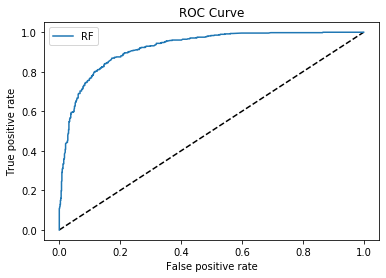

In [41]:
y_pred_proba = clf.predict_proba(X_train)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

### 4.d. Get the test metrics

In [42]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       278
           1       0.35      0.27      0.30       157

    accuracy                           0.56       435
   macro avg       0.49      0.49      0.49       435
weighted avg       0.53      0.56      0.54       435

[[200  78]
 [115  42]]


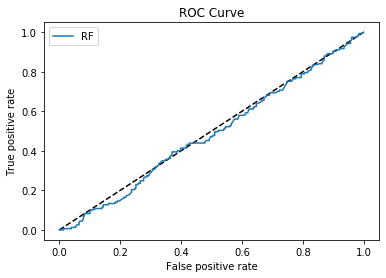

In [43]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

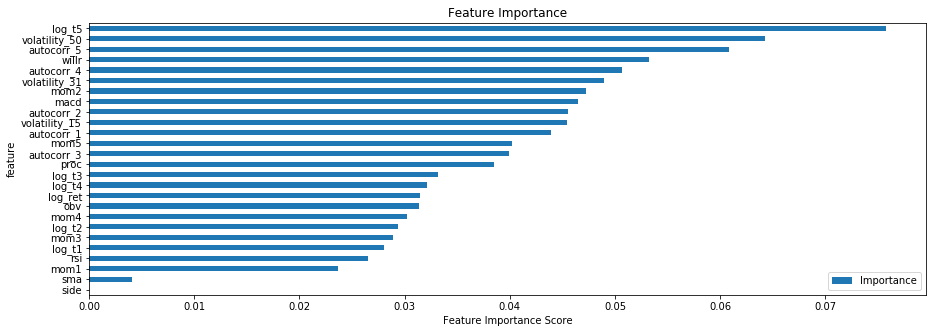

In [44]:
# Feature importance
title = 'Feature Importance'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance': clf.best_estimator_.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=True, inplace=True)
feat_imp.set_index('feature', drop=True, inplace=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

### Performace Summary

In [45]:
def get_daily_returns(intraday_returns):
    cum_rets = ((intraday_returns + 1).cumprod())
    daily_rets = cum_rets.resample('B').last()
    daily_rets = daily_rets.ffill().pct_change().dropna()
    return pd.Series(daily_rets.values, index=daily_rets.index.tz_localize('UTC'))

#### Primary model without meta labeling test performance

In [46]:
valid_dates = X_test.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [47]:
pf.show_perf_stats(primary_model_rets)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,359.1%
Cumulative returns,100.5%
Annual volatility,77.4%
Sharpe ratio,2.35
Calmar ratio,17.52
Stability,0.55
Max drawdown,-20.5%


#### Seconday model with meta labeling test performance

In [48]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [49]:
pf.show_perf_stats(daily_meta_rets)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,93.9%
Cumulative returns,35.3%
Annual volatility,47.0%
Sharpe ratio,1.63
Calmar ratio,10.15
Stability,0.58
Max drawdown,-9.2%


### Performance Analysis

#### Train + Test periods using the primary model

Note: the primary model doesn't use the train dataset to actually 'train' a model. So, the performance in the train period is still relevant.

/home/dan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,94.86,2018-01-15,2018-02-06,NaT,NaN
1,25.40,2018-01-04,2018-01-09,2018-01-11,6
2,0.00,2018-01-03,2018-01-03,2018-01-03,1
3,0.00,2018-01-03,2018-01-03,2018-01-03,1
4,0.00,2018-01-03,2018-01-03,2018-01-03,1


/home/dan/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


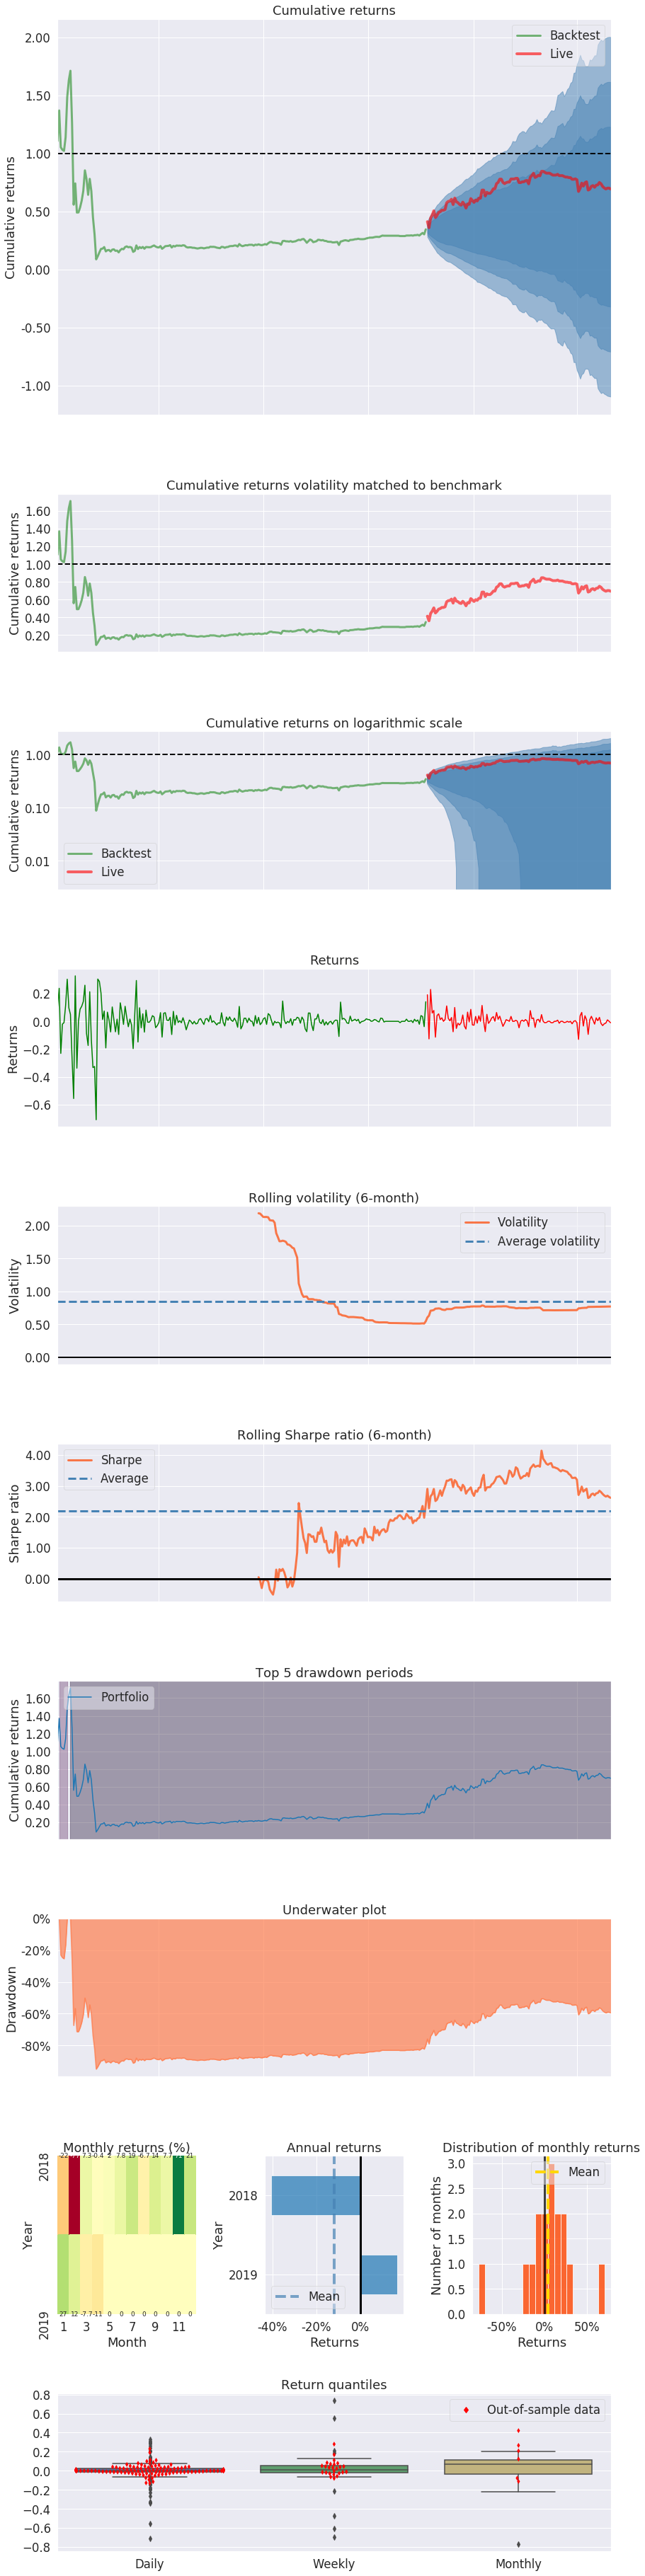

In [50]:
pf.create_returns_tear_sheet(get_daily_returns(labels.ret), live_start_date='2018-11-21')

#### Test period for the secondary model (Random Forest)

Because the train period performance is not relevant, show only the test performance.

In [51]:
y_pred_test = clf.predict(X_test)

performance = labels.loc[y_test.index, 'ret'] * y_pred_test
daily_performance = get_daily_returns(performance)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,93.9%
Cumulative returns,35.3%
Annual volatility,47.0%
Sharpe ratio,1.63
Calmar ratio,10.15
Stability,0.58
Max drawdown,-9.2%


/home/dan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.25,2018-12-20,2018-12-25,2018-12-28,7
1,7.54,2019-02-21,2019-04-03,NaT,NaN
2,6.57,2018-11-23,2018-11-29,2018-12-03,7
3,6.54,2018-12-14,2018-12-18,2018-12-20,5
4,5.15,2018-12-04,2018-12-06,2018-12-11,6


/home/dan/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


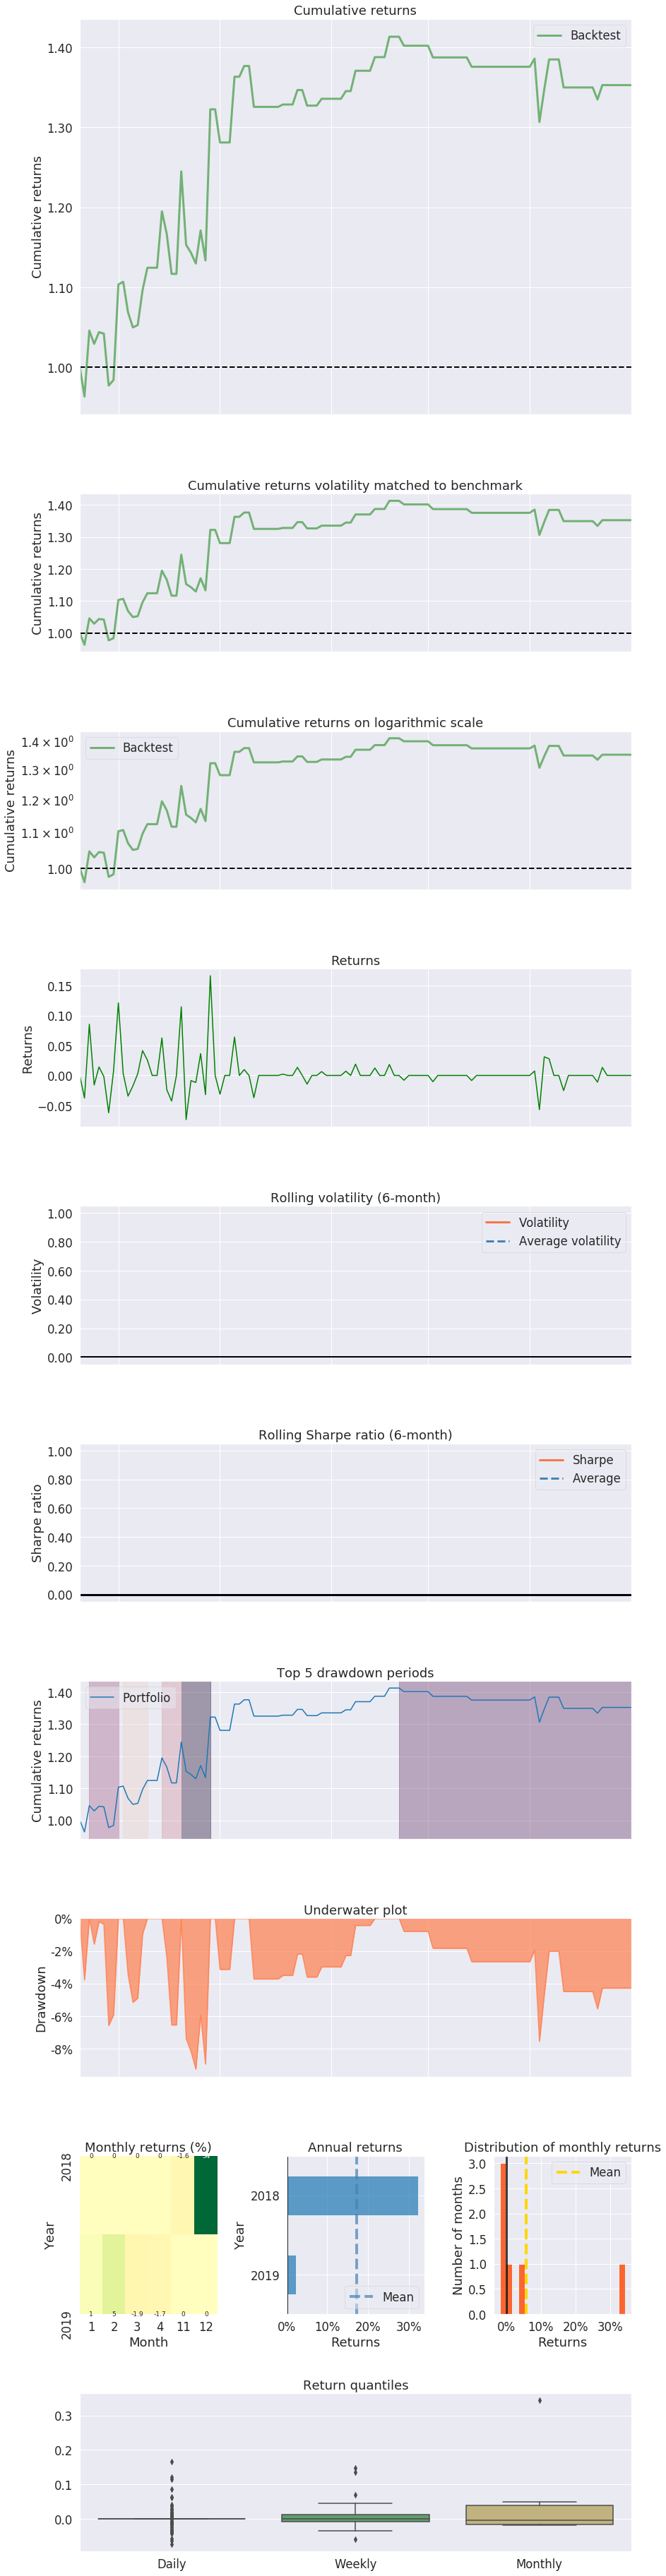

In [52]:
pf.create_returns_tear_sheet(daily_performance)